# Gender detection from color images

# Importing Libraries

In [1]:

from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries.

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.client import device_lib
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model,Sequential, load_model
from keras.optimizers import Adam, SGD, RMSprop, Nadam


In [ ]:
# pip install seaborn

In [ ]:
# pip install tensorflow

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# print(device_lib.list_local_devices())

# Displaying Images

In [2]:
picture_size = 48
folder_path = "./images/face_gender/"

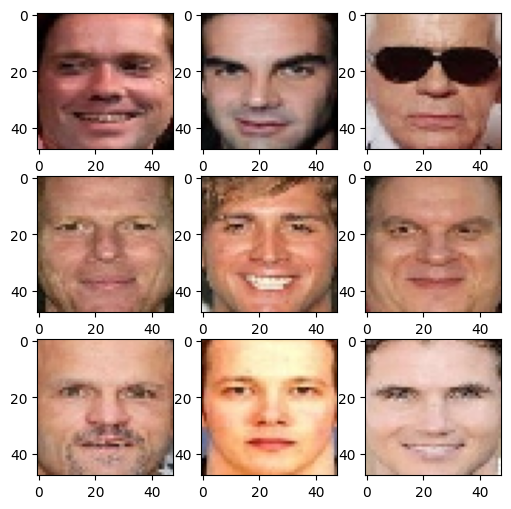

In [3]:

# Convert a PIL image from RGBA to RGB
def rgba_to_rgb(image):
    
    # Check if the image mode is RGBA
    if image.mode == 'RGBA':
        
        # Convert to RGB
        image = image.convert("RGB")
        
    return image
    

gender_folder_1 = "male"

plt.figure(figsize= (6, 6))

for i in range(1, 10, 1):
    
    plt.subplot(3,3,i)
    img = load_img(folder_path + "train/" + gender_folder_1 + "/" +
                  os.listdir(folder_path + "train/" + gender_folder_1)[i], target_size=(picture_size, picture_size), color_mode = 'rgba')
    
    img = rgba_to_rgb(img)
    plt.imshow(img)   
    
plt.show()


# Making Training and Validation Data (with generator)

In [4]:

# Converts an image to rgb, if the image is an rgba and otherwise returns the original image.
def rgba_to_rgb_generator(image):
    
    # If the input is a NumPy array, check the number of channels
    if isinstance(image, np.ndarray):
        
        if image.shape[-1] == 4:  # If the image has 4 channels (RGBA)
            
            # Discard the alpha channel (last channel)
            image = image[..., :3]
            
    # If the input is a PIL image, convert it from RGBA to RGB
    elif isinstance(image, Image.Image):
        
        if image.mode == 'RGBA':
            
            image = image.convert("RGB")

    return image


batch_size  = 128

# ImageDataGenerator with rescaling
datagen_train = ImageDataGenerator(preprocessing_function = rgba_to_rgb_generator, rescale=1./255)
datagen_val = ImageDataGenerator(preprocessing_function = rgba_to_rgb_generator, rescale=1./255)

# datagen_train = ImageDataGenerator(rescale=1./255)
# datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


test_set = datagen_val.flow_from_directory(folder_path+"validate",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


Found 56317 images belonging to 2 classes.
Found 15151 images belonging to 2 classes.


# Making Training and Validation Data (without generator, old fashioned way)

In [5]:

# Converts the gender label to an integer.
def convert_gender_label_to_int(gender_label):
    
   # Convert the extracted part to an integer.
   # The values are 'female' = 0 and 'male' = 1.
    
   gender_number = -1
    
   if gender_label == "male":
      gender_number = 1
   elif gender_label == "female":
      gender_number = 0
       
   return gender_number
    
# Converts an integer to an age label.
def convert_int_to_gender_label(gender_number):
    
   # Converts the integer 'gender_number' to the label "male" or "female".
    
   gender_label = ""
    
   if gender_number == 0:
      gender_label = "female"
   elif gender_number == 1:
      gender_label = "male"
       
   return gender_label

# Calculates and fills the vector gender_size with the number of files in each "gender" folder ("female" or "male").
# Choose train_or_validate to "train" or "validate". 
def get_nr_of_files_in_folders(gender_folders, folder_path, train_or_validate, gender_size):

    for j in range(len(gender_folders)):
        
       folder = folder_path + f"{train_or_validate}/" + gender_folders[j]

       # Using os.scandir() to get only files in a folder
       with os.scandir(folder) as entries:
            num_files = len([entry.name for entry in entries if entry.is_file()])

       gender_size.append(num_files)

# Convert a PIL image from RGBA to RGB
def rgba_to_rgb(image):
    
    # Check if the image mode is RGBA
    if image.mode == 'RGBA':
        
        # Convert to RGB
        image = image.convert("RGB")
        
    return image


# Check the time to run the program (loads 'x' (images) and creates 'y' ('gender labels') for train and validation data).
# Start time counter.
start_time_program = time.perf_counter()

images_data_train = []
images_labels_train = []

images_data_val = []
images_labels_val = []

gender_labels = ["female", "male"]
gender_folders = gender_labels.copy()

gender_size_train = []
gender_size_val = []

get_nr_of_files_in_folders(gender_folders, folder_path, "train", gender_size_train)

get_nr_of_files_in_folders(gender_folders, folder_path, "validate", gender_size_val)

# Function that creates the training data with the labels.

def createDataFromImagesTrainSet(gender_labels, gender_folders, gender_size_train):

   index = 0

   for j in range (len(gender_folders)):
    
      for i in range(gender_size_train[j]):

          img = load_img(folder_path + "train/" + gender_folders[j] + "/" +
                     os.listdir(folder_path + "train/" + gender_folders[j])[i], target_size=(picture_size, picture_size), color_mode = 'rgba')

          img = rgba_to_rgb(img)
          image_data_raw = img_to_array(img)
          image_data_raw = image_data_raw / 255.0
          images_labels_train.append(gender_labels[j])
          images_data_train.append(image_data_raw)
     
          index += 1

# Function that creates the testing data with the labels.

def createDataFromImagesValSet(gender_labels, gender_folders, gender_size_val):

   index = 0

   for j in range (len(gender_folders)):
    
      for i in range(gender_size_val[j]):

          img = load_img(folder_path + "validate/" + gender_folders[j] + "/" +
                     os.listdir(folder_path + "validate/" + gender_folders[j])[i], target_size = (picture_size, picture_size), color_mode = 'rgba')
          
          img = rgba_to_rgb(img)
          image_data_raw = img_to_array(img)
          image_data_raw = image_data_raw / 255.0
          images_labels_val.append(gender_labels[j])
          images_data_val.append(image_data_raw)
     
          index += 1


# Creates the training data with the labels.
createDataFromImagesTrainSet(gender_labels, gender_folders, gender_size_train)

# Creates the validation data with the labels.
createDataFromImagesValSet(gender_labels, gender_folders, gender_size_val)


# Convert to an np array.
    
images_labels_train = np.array(images_labels_train)
images_data_train = np.array(images_data_train)

images_labels_val = np.array(images_labels_val)
images_data_val = np.array(images_data_val)

# Stop time counter and write result.
end_time_program = time.perf_counter()
str_info = f"The time to run the program, where it (loads 'x' ('images') and creates 'y' ('gender labels') for train and validation data).\n"
diff_time = end_time_program - start_time_program
print(f"\n" + f"{str_info}It takes {diff_time:.0f} s ({diff_time // 60:.0f} min {diff_time % 60:.0f} sek).\n")



The time to run the program, where it (loads 'x' ('images') and creates 'y' ('gender labels') for train and validation data).
It takes 1660 s (27 min 40 sek).



In [6]:

print(len(images_labels_train))
print(len(images_data_val))
# print(images_data_val.shape)
print("")
print(len(gender_labels))
print(gender_folders)
# print(gender_labels.index('female'))
print(len(gender_size_train))
print(len(gender_size_val))

print(gender_size_train)
print(gender_size_val)


56317
15151

2
['female', 'male']
2
2
[27430, 28887]
[6753, 8398]


# Manipulating the input and output data.

In [7]:
        
# Generate a permutation of indices for train data.
permutation_train = np.random.permutation(len(images_data_train))

# Shuffle twice the train data and labels using the permutation.
images_data_train = images_data_train[permutation_train]
images_labels_train = images_labels_train[permutation_train]

permutation_train2 = np.random.permutation(len(images_data_train))

images_data_train = images_data_train[permutation_train2]
images_labels_train = images_labels_train[permutation_train2]

# Generate a permutation of indices for validation data.
permutation_val = np.random.permutation(len(images_data_val))

# Shuffle twice the validation data and labels using the permutation.
images_data_val = images_data_val[permutation_val]
images_labels_val = images_labels_val[permutation_val]

permutation_val2 = np.random.permutation(len(images_data_val))

images_data_val = images_data_val[permutation_val2]
images_labels_val = images_labels_val[permutation_val2]

# Make the age cathegories to integer values and one-hot encoding.
label_encoder = LabelEncoder()
integer_labels_train = label_encoder.fit_transform(images_labels_train)
integer_labels_val = label_encoder.transform(images_labels_val) 


images_labels_train_cat = to_categorical(integer_labels_train, num_classes = len(gender_labels))
images_labels_val_cat = to_categorical(integer_labels_val, num_classes = len(gender_labels))



In [8]:

# print(images_labels_train_cat[:20], images_labels_train[:20])
# print(images_labels_val_cat[:20], images_labels_val[:20])

print(len(integer_labels_train))
print(len(integer_labels_val))

# print(integer_labels_train)
# print(integer_labels_val)

# print(max(integer_labels_train))
# print(max(integer_labels_val))

# Check unique classes
unique_classes_train = np.unique(integer_labels_train)
print(f"Unique classes (train): {len(unique_classes_train)}")

unique_classes_val = np.unique(integer_labels_val)
print(f"Unique classes (val): {len(unique_classes_val)}")

unique_classes_gender = np.unique(gender_labels)
print(f"Unique classes (gender_labels): {len(unique_classes_gender)}")

print(len(gender_labels))
# print(gender_labels)


56317
15151
Unique classes (train): 2
Unique classes (val): 2
Unique classes (gender_labels): 2
2


# Model Building

In [37]:

# The neural network model with convutional and dense layers.

no_of_classes = len(gender_labels)

# The l2 regulariztion parameter (l2_score).
l2_score = 0.01

model = Sequential()

# Define input shape here.
model.add(Input(shape=(48, 48, 3)))  

#1st CNN layer
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128, (5,5), padding = 'same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3), padding = 'same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(512,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=l2(l2_score)))
# model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(1024, kernel_regularizer=l2(l2_score)))
# model.add(Dense(1024))
# model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(4024, kernel_regularizer=l2(l2_score)))
# model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 3d layer
model.add(Dense(1024, kernel_regularizer=l2(l2_score)))
# model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer (no_of_classes = 2 gender cathegories).
model.add(Dense(no_of_classes, activation = 'softmax'))

my_learning_rate = 0.0005

# Optimizer Adam (there are also SGD, RMSprop and Nadam).
opt = Adam(learning_rate = my_learning_rate)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1024)           │         4,09

 Total params: 16,153,882 (61.62 MB)

 Trainable params: 16,139,306 (61.57 MB)

 Non-trainable params: 14,576 (56.94 KB)

In [ ]:
# print(no_of_classes)

# Fitting the Model with Training and Validation Data 

In [39]:

# Fitting the Model with Training and Validation Data. Using callbacks as ModelCheckpoint, EarlyStopping and ReduceLROnPlateau.

checkpoint = ModelCheckpoint("./modelcheck_gender.keras", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 60

# Optimizer Adam (there are also SGD, RMSprop and Nadam).
opt = Adam(learning_rate = my_learning_rate)
model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])


# Training models.

In [ ]:

# Fit the model with the generator model.

# history = model.fit(train_set,
#                    steps_per_epoch = train_set.n // train_set.batch_size,
#                    epochs = epochs,
#                    validation_data = test_set,
#                    validation_steps = test_set.n // test_set.batch_size,
#                    callbacks = callbacks_list
#                    )


In [ ]:

# Fit the model with the generator model.

history = model.fit(train_set,
                    steps_per_epoch = train_set.n // train_set.batch_size,
                    epochs = epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n // test_set.batch_size,
                    callbacks = callbacks_list
                    )


In [40]:

# Fit the model where x (images) and y (gender) has been "loaded" from file.

# Check time to run the program (train the neural network model).
# Start time counter.
start_time_program = time.perf_counter()

batch_size_img = 128

history = model.fit(x = images_data_train, y = images_labels_train_cat,
                    steps_per_epoch = max(len(images_data_train) // batch_size_img - 5 , 1),
                    epochs = epochs,
                    batch_size = batch_size_img,
                    validation_data = (images_data_val, images_labels_val_cat),
                    validation_steps = max(len(images_data_val) // batch_size_img - 5, 1),
                    callbacks = callbacks_list
                    )

# Stop time counter and write result.
end_time_program = time.perf_counter()
str_info = f"The time to run the program, where it trains the neural network"
diff_time = end_time_program - start_time_program
print(f"\n" + f"{str_info}, is given by {diff_time:.0f} s ({diff_time // 60:.0f} min {diff_time % 60:.0f} sek).\n")


Epoch 1/60
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.7834 - loss: 27.3772
Epoch 1: val_accuracy improved from -inf to 0.56368, saving model to ./modelcheck_gender.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 319s 725ms/step - accuracy: 0.7836 - loss: 27.3435 - val_accuracy: 0.5637 - val_loss: 1.4581 - learning_rate: 5.0000e-04
Epoch 2/60
  6/434 ━━━━━━━━━━━━━━━━━━━━ 4:58 698ms/step - accuracy: 0.8866 - loss: 0.9997

D:\Program\Programming\Anaconda3\envs\Lia_AI1\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.56368 to 0.71325, saving model to ./modelcheck_gender.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8837 - loss: 1.0179 - val_accuracy: 0.7132 - val_loss: 1.2388 - learning_rate: 5.0000e-04
Epoch 3/60
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.8903 - loss: 0.9101
Epoch 3: val_accuracy improved from 0.71325 to 0.84589, saving model to ./modelcheck_gender.keras
434/434 ━━━━━━━━━━━━━━━━━━━━ 311s 717ms/step - accuracy: 0.8903 - loss: 0.9101 - val_accuracy: 0.8459 - val_loss: 1.2233 - learning_rate: 5.0000e-04
Epoch 4/60
  6/434 ━━━━━━━━━━━━━━━━━━━━ 4:45 667ms/step - accuracy: 0.8533 - loss: 1.0565
Epoch 4: val_accuracy did not improve from 0.84589
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8587 - loss: 1.0552 - val_accuracy: 0.5488 - val_loss: 1.4789 - learning_rate: 5.0000e-04
Epoch 5/60
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.8933 - loss: 0.7711
Epoch 5: val_accuracy did not improve from 0.

# Saving the models (and loading checkpoint model with best accuracy).

In [41]:

model.save(filepath = "model_gender.keras", include_optimizer = False)

model.save(filepath = "model_all_gender.keras")

model2 = load_model("modelcheck_gender.keras")


In [42]:

# Load the models from disk for prediction, accuracy and confusion matrix.

model2 = load_model("modelcheck_gender.keras")
model = load_model("model_all_gender.keras")


# Calculate the accuracy from the validation data.

In [43]:

# Create predictions from the validation data (from last trained model (model) and best accuracy checkpoint model (model2)).

pred_val = model.predict(images_data_val)
pred_val2 = model2.predict(images_data_val)


474/474 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step
474/474 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step


In [44]:

# Make predictions and evaluate the model.

# Accuracy from last trained model (model).

pred_labels_val = np.argmax(pred_val, axis = 1)
true_labels_val = np.argmax(images_labels_val_cat, axis = 1)
accuracy = np.mean(pred_labels_val == true_labels_val)
print(f"Accuracy: {accuracy}")

# Accuracy from best accuracy checkpoint model (model2).

pred_labels_val2 = np.argmax(pred_val2, axis = 1)
accuracy_best = np.mean(pred_labels_val2 == true_labels_val)
print(f"Accuracy (last best prediction): {accuracy_best}")


Accuracy: 0.9662068510329351
Accuracy (last best prediction): 0.968384925087453


# Plotting Accuracy & Loss

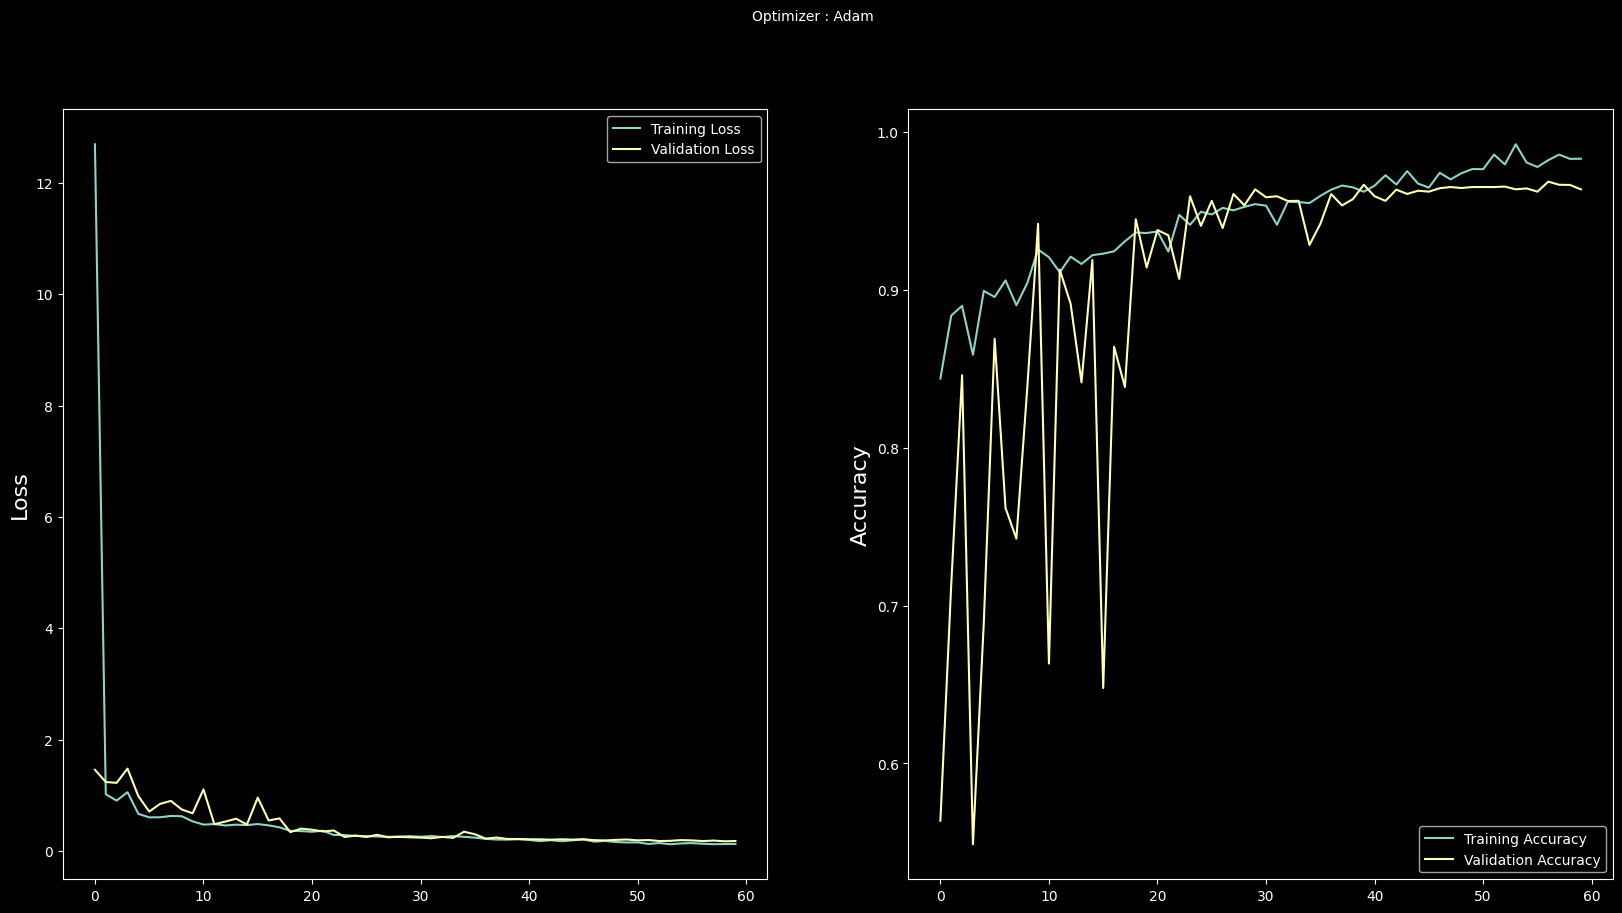

In [45]:

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


# Confusion matrix

Unique classes 2: 2
Unique classes 1: 2
Unique classes true: 2


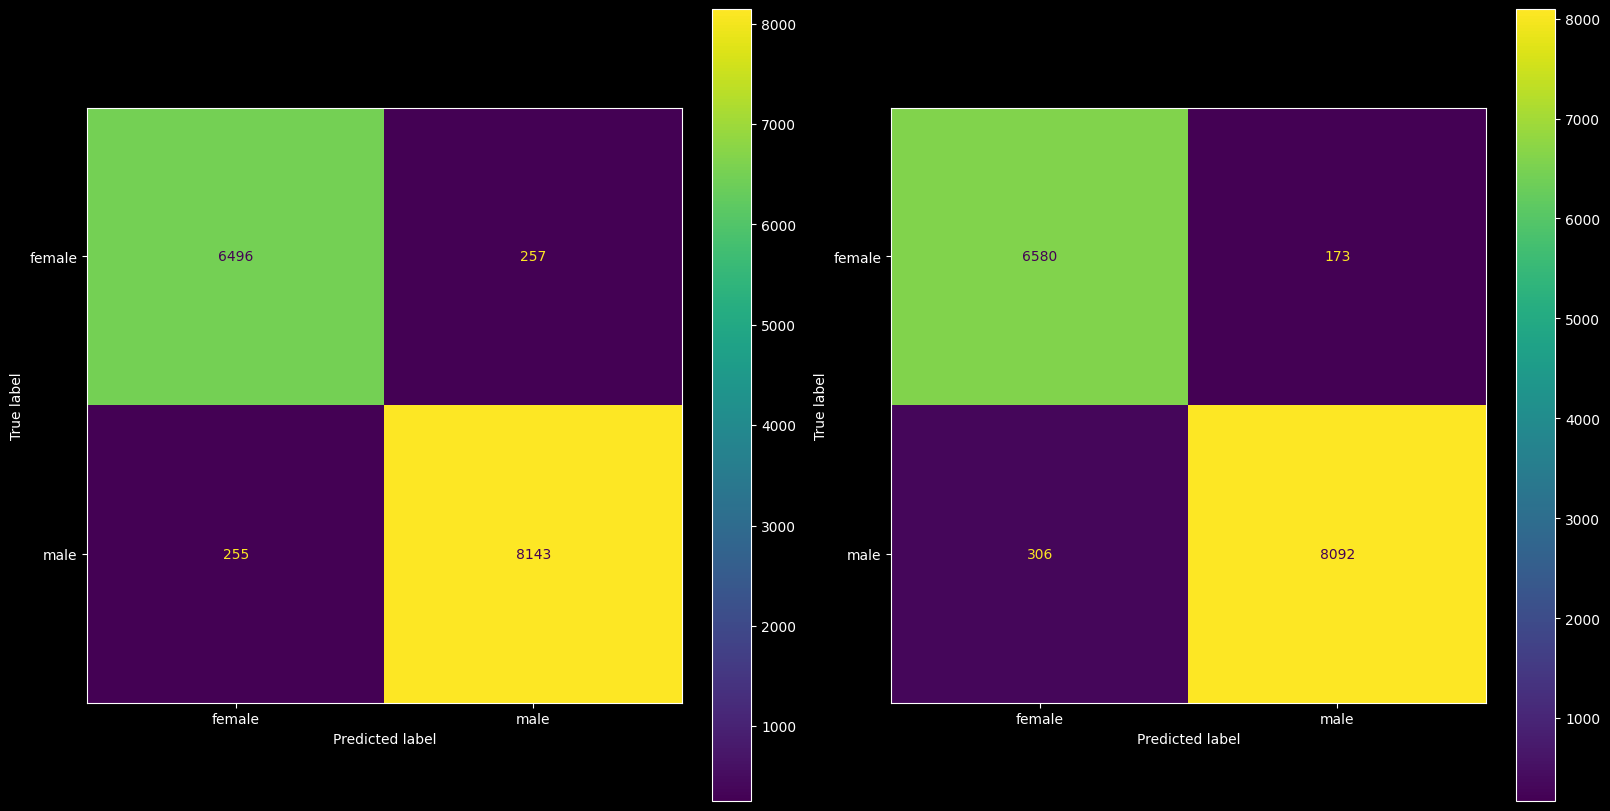

In [46]:

# Calculate the confusion matrix from the predicted and true values (from model (last saved configuration) and 
# model 2 (the best configuration)).

cm1 = confusion_matrix(true_labels_val, pred_labels_val)
cm2 = confusion_matrix(true_labels_val, pred_labels_val2)

# Check unique classes                                          
unique_classes = np.unique(pred_labels_val2)
print(f"Unique classes 2: {len(unique_classes)}")

unique_classes1 = np.unique(pred_labels_val)
print(f"Unique classes 1: {len(unique_classes1)}")

unique_classes_true = np.unique(true_labels_val)
print(f"Unique classes true: {len(unique_classes_true)}")

fig, axs = plt.subplots(1, 2, figsize = (16, 8), layout='constrained')
ConfusionMatrixDisplay(cm1, display_labels = gender_labels).plot(ax=axs[0])
ConfusionMatrixDisplay(cm2, display_labels = gender_labels).plot(ax=axs[1])
